In [ ]:
# To have reproducible results and compare them

import numpy as np 
import tensorflow as tf

nr_seed = 2019

np.random.seed(nr_seed)
tf.set_random_seed(nr_seed)

In [ ]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 32

# Loading & Merging

In [ ]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
print(new_train.shape)
print(old_train.shape)

In [ ]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

# path columns
new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()
train_df.head()

## Train - Valid split

In [ ]:
# Not used in version 5
#train_df, val_df = train_test_split(train_df, shuffle=True, stratify=train_df.diagnosis, test_size=0.1, random_state=2019)

In [ ]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

### Process Images

In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

In [ ]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values
y_val = pd.get_dummies(val_df['diagnosis']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

In [ ]:
y_train = y_train_multi
y_val = y_val_multi

In [ ]:
# delete the uneeded df
del new_train
del old_train
del val_df
gc.collect()

# Creating keras callback for QWK

---

I had to change this function, in order to consider the best kappa score among all the buckets.

In [ ]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Data Generator

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [ ]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

# Training & Evaluation

In [ ]:
#train_df = train_df.reset_index(drop=True)
bucket_num = 5
div = round(train_df.shape[0]/bucket_num)

In [ ]:
df_init = {
    'val_loss': [0.0],
    'val_acc': [0.0],
    'loss': [0.0], 
    'acc': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [ ]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,10,15,15,20,20,30]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [ ]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

In [26]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,val_loss,val_acc,loss,acc,bucket,kappa
0,0,0.228750,0.909667,0.346742,0.851332,0.0,0.756607
1,1,0.191009,0.918733,0.232196,0.907174,0.0,0.823773
2,2,0.282895,0.876188,0.204500,0.918697,0.0,0.540196
3,3,0.181066,0.930366,0.189054,0.923799,0.0,0.845260
4,4,0.195960,0.926980,0.179921,0.928718,0.0,0.835850
5,0,0.223175,0.917914,0.187330,0.928854,1.0,0.854134
6,1,0.213088,0.913654,0.181979,0.931041,1.0,0.847931
7,2,0.213421,0.912398,0.167328,0.935778,1.0,0.709995
8,3,0.189813,0.924522,0.165229,0.937008,1.0,0.789293
9,4,0.217555,0.915074,0.159799,0.937827,1.0,0.852134


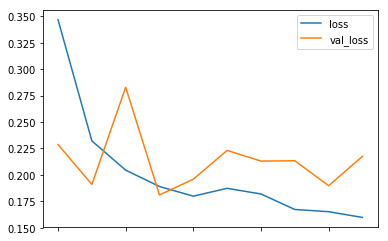

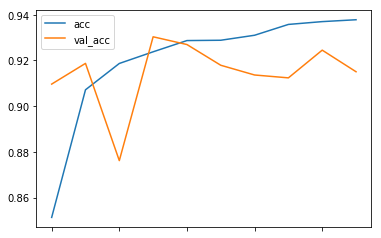

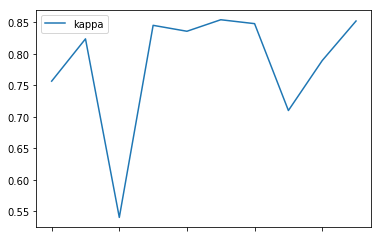

In [27]:
results[['loss', 'val_loss']].plot()
results[['acc', 'val_acc']].plot()
results[['kappa']].plot()
results.to_csv('model_results.csv',index=False)

# Find best threshold

In [ ]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y1 = y_val_pred > best_threshold
y1 = y1.astype(int).sum(axis=1) - 1
y2 = y_val.sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Threshold: {}'.format(best_threshold))
print('Validation QWK score with best_threshold: {}'.format(score))

y1 = y_val_pred > .5
y1 = y1.astype(int).sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Validation QWK score with .5 threshold: {}'.format(score))